In [1]:

# Duane Myklejord, April 2023
# Adapted from: https://github.com/dmyklejord/selfsupervised-learning-for-image-classification/tree/main


# Imports
import torch
from torch import nn
import torchvision
import copy
import numpy as np
import os
import matplotlib.pyplot as plt

from lightly.models.modules import SimCLRProjectionHead
from sklearn.manifold import TSNE

import helper_train
import helper_evaluate
import helper_data

In [2]:
# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 100

# Set to run on mps if available (i.e. Apple's GPU).
# mps is a new pytorch feature, so we check that
# it's also available with the user's pytorch install.
DEVICE = 'mps' if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() \
        else 'cuda' if hasattr(torch.backends, "cuda") and torch.cuda.is_available() \
        else 'cpu'

helper_evaluate.set_deterministic
helper_evaluate.set_all_seeds(RANDOM_SEED)

In [3]:
## Getting the data:
# The directory should contain folders of images, with each folder
# having images of a certain class. Example: 2 folders for 2 classes.
# The folder names should be the class names.
data_location=('data/images')

train_loader, test_loader = helper_data.get_dataloaders(data_location, batch_size=BATCH_SIZE)

# To get the class names from the folder names:
class_names = [f.name for f in os.scandir(data_location) if f.is_dir()]

In [4]:
# The model itself:
class SimCLR(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimCLRProjectionHead(512, 512, 128)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

# Building the backbone. Here is where you can change it to whatever you
resnet = torchvision.models.resnet18(weights='DEFAULT')
backbone = nn.Sequential(*list(resnet.children())[:-1]) # removes FC layer

# In this case, we want to use SimCLR with an Adam optimizer:
model = SimCLR(backbone).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# This is for logging the metadata from the run:
comp_log_dict = {'final_epoch_loss':[],
                'final_batch_loss': [],
                'final_accuracy': [],
                'training_time': [],
                'model': model.__class__.__name__,
                'learning_rate': LEARNING_RATE,
                'batch_size': BATCH_SIZE,
                'num_epochs': NUM_EPOCHS,
                'optimizer_type': optimizer.__class__.__name__
                }

Current model: SimCLR_0.0001LR
Epoch: 001/100 | Batch 0000/0015 | Loss: 5.3864
Epoch: 001/100 | Batch 0004/0015 | Loss: 4.8846
Epoch: 001/100 | Batch 0008/0015 | Loss: 4.5170
Epoch: 001/100 | Batch 0012/0015 | Loss: 4.4132
Time elapsed: 1.07 min
Current model: SimCLR_0.0001LR
Epoch: 002/100 | Batch 0000/0015 | Loss: 4.3801
Epoch: 002/100 | Batch 0004/0015 | Loss: 4.3313
Epoch: 002/100 | Batch 0008/0015 | Loss: 4.2606
Epoch: 002/100 | Batch 0012/0015 | Loss: 4.2092
Time elapsed: 2.16 min
Current model: SimCLR_0.0001LR
Epoch: 003/100 | Batch 0000/0015 | Loss: 4.1165
Epoch: 003/100 | Batch 0004/0015 | Loss: 4.1593
Epoch: 003/100 | Batch 0008/0015 | Loss: 4.1412
Epoch: 003/100 | Batch 0012/0015 | Loss: 4.1346
Time elapsed: 3.22 min
Current model: SimCLR_0.0001LR
Epoch: 004/100 | Batch 0000/0015 | Loss: 4.0529
Epoch: 004/100 | Batch 0004/0015 | Loss: 4.0622
Epoch: 004/100 | Batch 0008/0015 | Loss: 4.0962
Epoch: 004/100 | Batch 0012/0015 | Loss: 4.0349
Time elapsed: 4.36 min
Current model: S

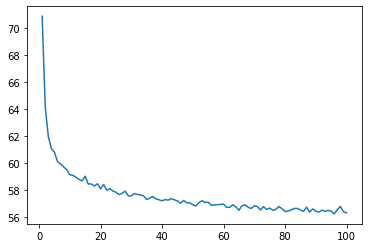

In [5]:
# Train the model, returns a dict of the training loss. Change the
# function call to train the model you want.
model_name=f'{model.__class__.__name__}_{LEARNING_RATE}LR'

# If you have an already trained model, it can be loaded. Training steps can then be skipped.
# model.load_state_dict(torch.load(f'{model_name}.pt')) # to load a pre-trained model

training_log_dict = helper_train.train_simclr(num_epochs=NUM_EPOCHS, model=model,
                    optimizer=optimizer, device=DEVICE,
                    train_loader=train_loader,
                    save_model=model_name,
                    logging_interval=4,
                    save_epoch_states=False)

# Saving the log of training loss to a csv
import csv
w = csv.writer(open(model_name+'_TrainingLossLog.csv', "w"))
for key, val in training_log_dict.items():
    w.writerow([key, val])

# Plot the epoch losses
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), training_log_dict['train_loss_per_epoch'])
plt.savefig(model_name+'_EpochLossPlot.png')

In [6]:
# Inference:
# Passing images through the trained backbone to get their embeddings/features/latent_space etc.
train_X, train_y, test_X, test_y, test_images, train_images = helper_evaluate.get_features(model, train_loader, test_loader, DEVICE)
np.savez(model_name+'_features', train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y, test_images=test_images, train_images=train_images)

# Trains a linear classifier on the data to determine accuracy and makes a confusion matrix.
pred_labels = helper_evaluate.linear_classifier(train_X, train_y, test_X, test_y)
confusion_matrix, accuracy = helper_evaluate.make_confusion_matrix(pred_labels, test_y, len(class_names))
helper_evaluate.visualize_confusion_matrix(confusion_matrix, accuracy, class_names, model_name)

# Writing and saving metadata from the run:
comp_log_dict['final_epoch_loss'] = training_log_dict['train_loss_per_epoch'][-1]
comp_log_dict['final_batch_loss'] = training_log_dict['train_loss_per_batch'][-1]
comp_log_dict['training_time'] = training_log_dict['total_time'][-1]
comp_log_dict['final_accuracy'] = accuracy

w = csv.writer(open(model_name+'_Meta.csv', "w"))
for key, val in comp_log_dict.items():
    w.writerow([key, val])

Step [0/15]	 Computing features...
Features shape (1920, 512)
Step [0/4]	 Computing features...
Features shape (500, 512)
Logistic Regression Accuracy:  0.818


/Users/duanemyklejord/opt/anaconda3/envs/GPU_Pytorch3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[87  6  2  1  0]
 [ 9 89  4  1  6]
 [ 2  1 88  3  7]
 [ 2  1  4 79  9]
 [ 5  2 13 13 66]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        96
           1       0.90      0.82      0.86       109
           2       0.79      0.87      0.83       101
           3       0.81      0.83      0.82        95
           4       0.75      0.67      0.71        99

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



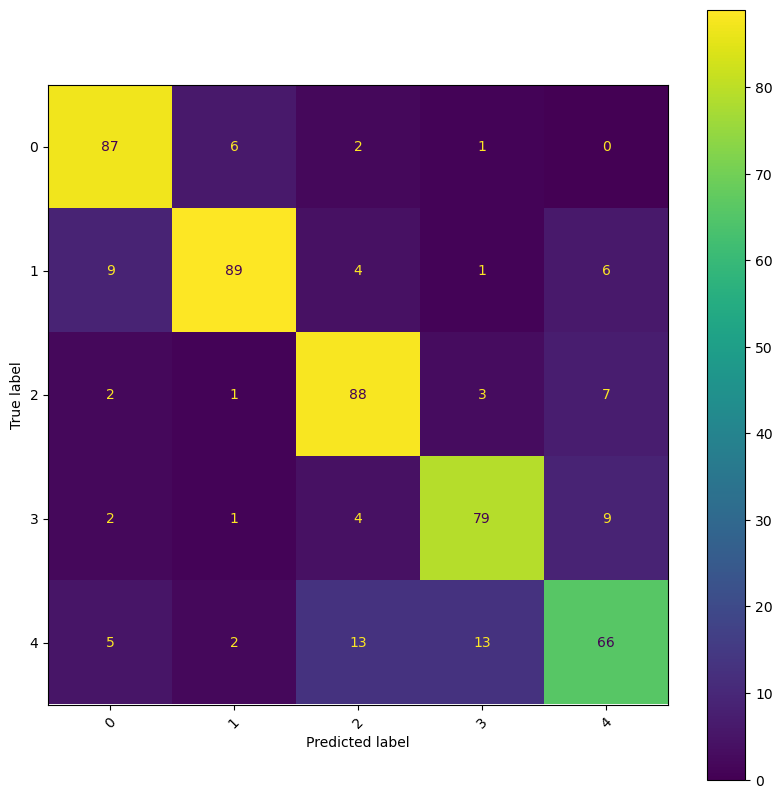

In [8]:
# TSNE analysis and visualization:
tsne_xtest = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20, n_iter=1000).fit_transform(test_X)
helper_evaluate.visualize_tsne(model_name, tsne_xtest, class_names, test_y, close_fig=True)

# An interactive TSNE visualization, opens an HTML in browser. Easily sharable. 
helper_evaluate.visualize_hover_images(model_name, tsne_xtest, test_images, pred_labels, class_names, test_y, showplot=True)

# Calculate classification statistics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

confusion = confusion_matrix(test_y, pred_labels)
report = classification_report(test_y, pred_labels)

# Print the classification statistics
print('Confusion Matrix:')
print(confusion)
print('\nClassification Report:')
print(report)

display = ConfusionMatrixDisplay(confusion)
fig, ax = plt.subplots(figsize=(10, 10))
display.plot(ax=ax, xticks_rotation=45)
plt.show()

# # For saving time with pre-trained models:
# model.load_state_dict(torch.load(f'{model_name}.pt')) # to load a pre-trained model

# # to load the embedded space that you've already found:
# features = np.load(model_name+'_features.npz')          
# train_X, train_y, test_X, test_y, test_images = features['train_X'], features['train_y'], features['test_X'], features['test_y'], features['test_images']   # Gets the embedded space into a usable format.